In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import gpflux
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

from sklearn.metrics import mean_squared_error, mean_absolute_error
from properscoring import crps_gaussian

tf.keras.backend.set_floatx("float64")

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data, weekday_train_test_save
from useful_fun import plot_distribution_gpflux, percentage_outof_CI, number_outof_CI

In [2]:
# load data

# whole dataset
data = get_birth_data()

# weekday train/test split
weekday_train = pd.read_csv('../../data/weekday_train.csv')
weekday_x_train, weekday_y_train = separate_data(weekday_train)
weekday_test = pd.read_csv('../../data/weekday_test.csv')
weekday_x_test, weekday_y_test = separate_data(weekday_test)

weekday_x_train = weekday_x_train.numpy().reshape(-1,1)
weekday_y_train = weekday_y_train.numpy().reshape(-1,1)
weekday_x_test = weekday_x_test.numpy().reshape(-1,1)
weekday_y_test = weekday_y_test.numpy().reshape(-1,1)

# weekend train/test split
weekend_train = pd.read_csv('../../data/weekend_train.csv')
weekend_x_train, weekend_y_train = separate_data(weekend_train)
weekend_test = pd.read_csv('../../data/weekend_test.csv')
weekend_x_test, weekend_y_test = separate_data(weekend_test)

weekend_x_train = weekend_x_train.numpy().reshape(-1,1)
weekend_y_train = weekend_y_train.numpy().reshape(-1,1)
weekend_x_test = weekend_x_test.numpy().reshape(-1,1)
weekend_y_test = weekend_y_test.numpy().reshape(-1,1)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
weekday_pos, weekday_labels = get_xticks(data[data.weekday==1])
weekend_pos, weekend_labels = get_xticks(data[data.weekday==0])

2022-08-30 22:17:15.770358: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 22:17:16.339693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5


# Weekdays

In [3]:
def build_train_2layer_dgp(kernel1, kernel2, x_train, y_train, x_test, y_test, pos, labels, num_inducing=1000, batch_size=500):
    Z = np.linspace(x_train.min(), x_train.max(), num_inducing).reshape(-1, 1)

    # layer 1 set up
    inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer1 = gpflux.layers.GPLayer(
        kernel1, 
        inducing_variable1, 
        num_data=len(x_train), 
        num_latent_gps=y_train.shape[1]
    )

    # layer 2 set up
    inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer2 = gpflux.layers.GPLayer(
        kernel2,
        inducing_variable2,
        num_data=len(x_train),
        num_latent_gps=y_train.shape[1],
        mean_function=gpflow.mean_functions.Zero()
    )

    # model construction
    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
    two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)

    model = two_layer_dgp.as_training_model()
    model.compile(tf.optimizers.Adam(0.01))

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    ]
    history = model.fit({"inputs": x_train, "targets": y_train}, batch_size=batch_size, epochs=500, verbose=0, callbacks=callbacks)
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].plot(history.history["loss"])
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Objective = neg. ELBO")
    ax[0].set_title('ELBO during training')
    ax[1].plot(history.history["lr"])
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Learning rate")
    ax[1].set_title('Learning rate during training')
    plt.show()

    model = two_layer_dgp.as_prediction_model()

    print('Training Set')
    fitted_values = model(x_train)
    mean_train = fitted_values.y_mean.numpy().squeeze()
    noise = model.layers[-1].likelihood.variance.numpy()
    var_train = fitted_values.f_var.numpy().squeeze() + noise
    plot_distribution_gpflux(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    print('Testing Set')
    pred = model(x_test)
    mean_test = pred.y_mean.numpy().squeeze()
    var_test = pred.f_var.numpy().squeeze() + noise
    plot_distribution_gpflux(x_test, y_test, mean_test, var_test, pos, labels)

    print('Train ELBO, MSE, MAE: ', two_layer_dgp.elbo((x_train, y_train)).numpy(), 
                                    mean_squared_error(y_train, mean_train), 
                                    np.mean(crps_gaussian(y_train, mean_train, np.sqrt(var_train))),
                                    percentage_outof_CI(y_train, mean_train, var_train))

    print('Test ELBO, MSE, MAE: ', two_layer_dgp.elbo((x_test, y_test)).numpy(), 
                                    mean_squared_error(y_test, mean_test), 
                                    np.mean(crps_gaussian(y_test, mean_test, np.sqrt(var_test))),
                                    percentage_outof_CI(y_test, mean_test, var_test))

    print_summary(two_layer_dgp, fmt="notebook")

2022-08-29 18:42:29.500794: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-29 18:42:34.481733: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8654c30


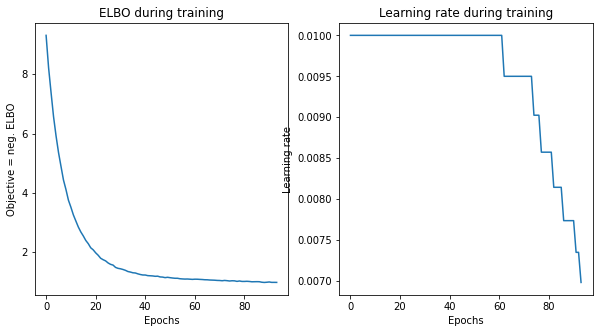

Training Set


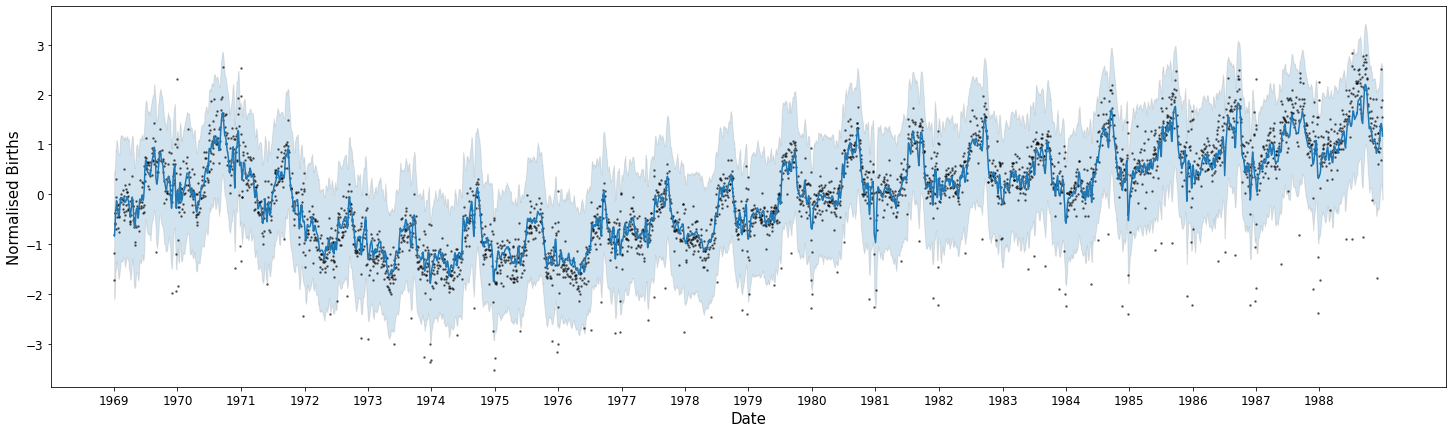

Testing Set


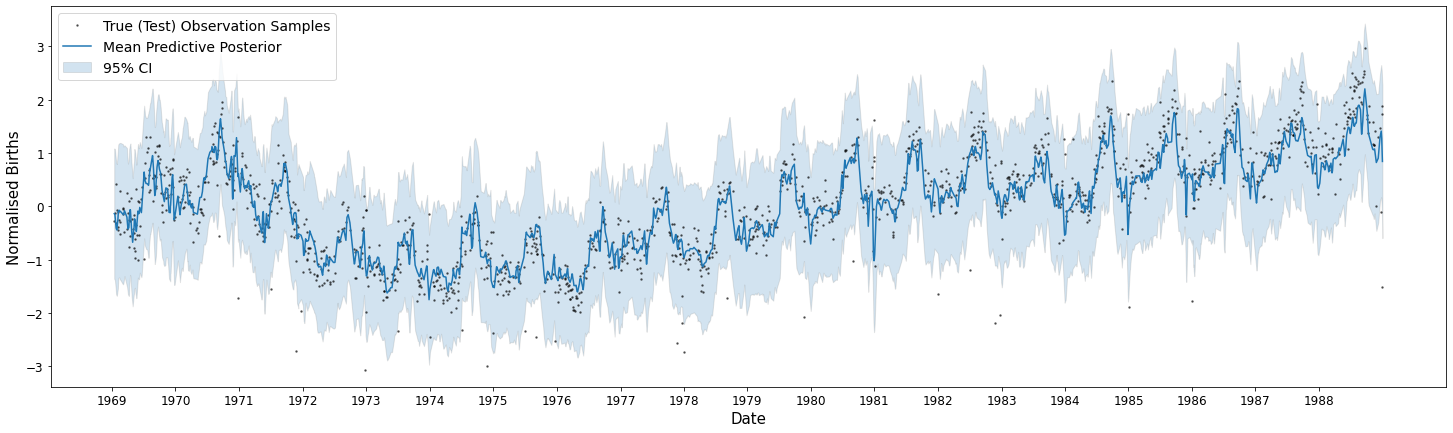

Train ELBO, MSE, MAE:  -3568.912524908049 0.1657697514204945 0.8052605732490243 36.06264898286764
Test ELBO, MSE, MAE:  -3906.63693267385 0.19733214678756994 0.8013208841683773 34.796375403897315


name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[6.70016459e-02...
DeepGP.f_layers[0]._trainable_weights[1],ResourceVariable,,,True,"(1, 500500)",float64,"[[9.80164705e-01, 7.61493822e-03, -2.96416913e-04..."
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[0] DeepGP.f_layers[0]._metrics[0].total,ResourceVariable,,,False,(),float64,0.005090483117486591
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[1] DeepGP.f_layers[0]._metrics[0].count,ResourceVariable,,,False,(),float64,12.0
DeepGP.f_layers[0]._self_tracked_trackables[1].variance DeepGP.f_layers[0].kernel.variance,Parameter,Softplus,,True,(),float64,0.25655896813993107
DeepGP.f_layers[0]._self_tracked_trackables[1].lengthscales DeepGP.f_layers[0].kernel.lengthscales,Parameter,Softplus,,True,(),float64,3.203398610994704
DeepGP.f_layers[0]._self_tracked_trackables[2].Z DeepGP.f_layers[0].inducing_variable.Z,Parameter,Identity,,True,"(1000, 1)",float64,[[1.47248425e+00...
DeepGP.f_layers[0]._self_tracked_trackables[4] DeepGP.f_layers[0].q_mu,Parameter,Identity,,True,"(1000, 1)",float64,[[6.70016459e-02...
DeepGP.f_layers[0]._self_tracked_trackables[5] DeepGP.f_layers[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 1000, 1000)",float64,"[[[9.65879340e-01, 0.00000000e+00, 0.00000000e+00..."
DeepGP.f_layers[1]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[-1.21759754e+00...


In [8]:
build_train_2layer_dgp(gpflow.kernels.RBF(), gpflow.kernels.RBF(), 
                        weekday_x_train, weekday_y_train, weekday_x_test, weekday_y_test, weekday_pos, weekday_labels, 
                        num_inducing=1000, batch_size=500)

2022-08-30 22:17:22.423051: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-30 22:17:27.869790: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8b4fb80


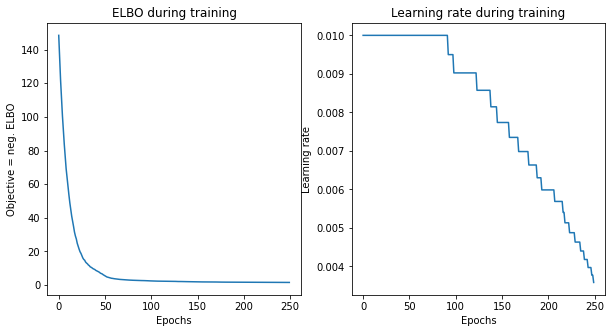

Training Set


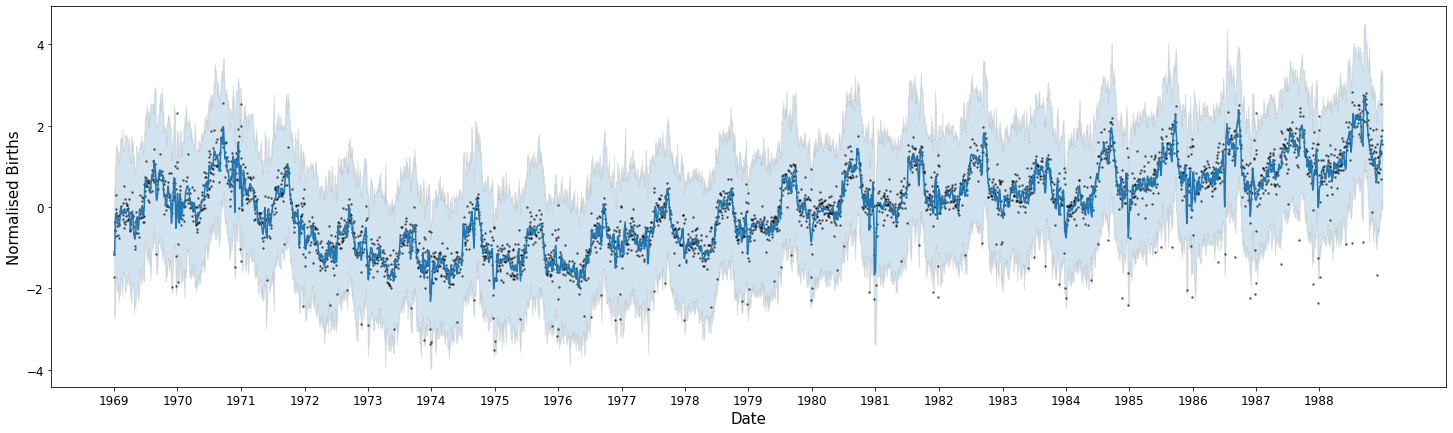

Testing Set


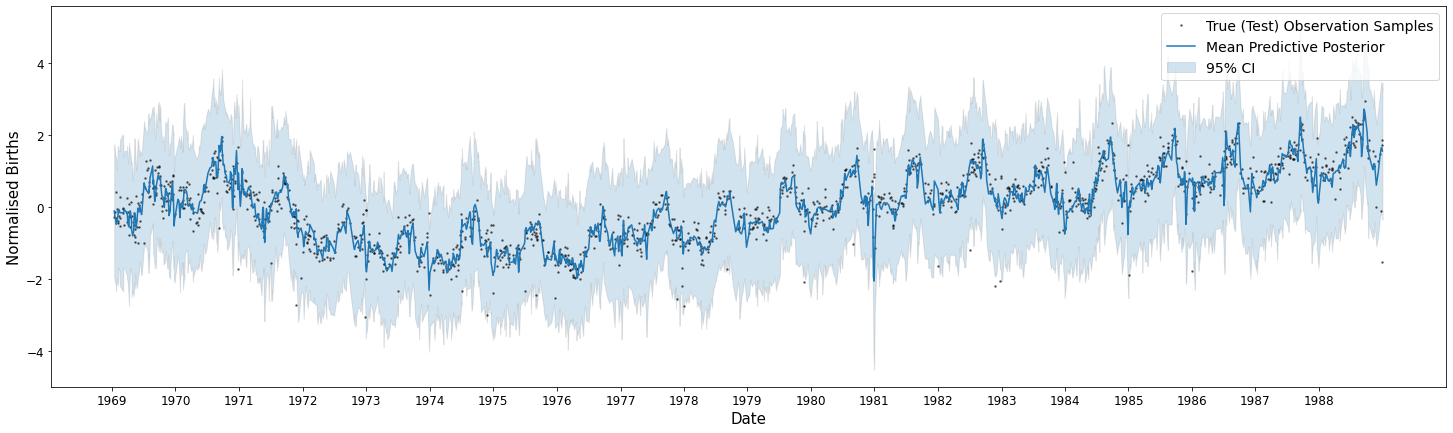

Train ELBO, MSE, MAE:  -5633.9791969103935 0.15325826247098384 0.8077270438463804 23.58457278281702
Test ELBO, MSE, MAE:  -6477.630854551922 0.21538290112376005 0.8172675858944011 20.682315291907045


name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[2.25731633e-01...
DeepGP.f_layers[0]._trainable_weights[1],ResourceVariable,,,True,"(1, 500500)",float64,"[[6.75412307e-01, -1.46788357e-01, 1.59856166e-02..."
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[0] DeepGP.f_layers[0]._metrics[0].total,ResourceVariable,,,False,(),float64,0.34149796917132524
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[1] DeepGP.f_layers[0]._metrics[0].count,ResourceVariable,,,False,(),float64,12.0
DeepGP.f_layers[0]._self_tracked_trackables[1].variance DeepGP.f_layers[0].kernel.variance,Parameter,Softplus,,True,(),float64,1.3966582458655121
DeepGP.f_layers[0]._self_tracked_trackables[1].lengthscales DeepGP.f_layers[0].kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.233630776496868
DeepGP.f_layers[0]._self_tracked_trackables[2].Z DeepGP.f_layers[0].inducing_variable.Z,Parameter,Identity,,True,"(1000, 1)",float64,[[1.30783347e+00...
DeepGP.f_layers[0]._self_tracked_trackables[4] DeepGP.f_layers[0].q_mu,Parameter,Identity,,True,"(1000, 1)",float64,[[2.25731633e-01...
DeepGP.f_layers[0]._self_tracked_trackables[5] DeepGP.f_layers[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 1000, 1000)",float64,"[[[6.24413761e-01, 0.00000000e+00, 0.00000000e+00..."
DeepGP.f_layers[1]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[-2.25297810e-01...


In [4]:
build_train_2layer_dgp(gpflow.kernels.RBF(1), gpflow.kernels.RBF(30), 
                        weekday_x_train, weekday_y_train, weekday_x_test, weekday_y_test, weekday_pos, weekday_labels, 
                        num_inducing=1000, batch_size=500)

# Weekends

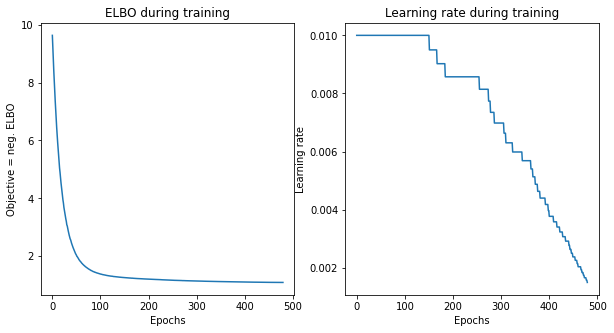

Training Set


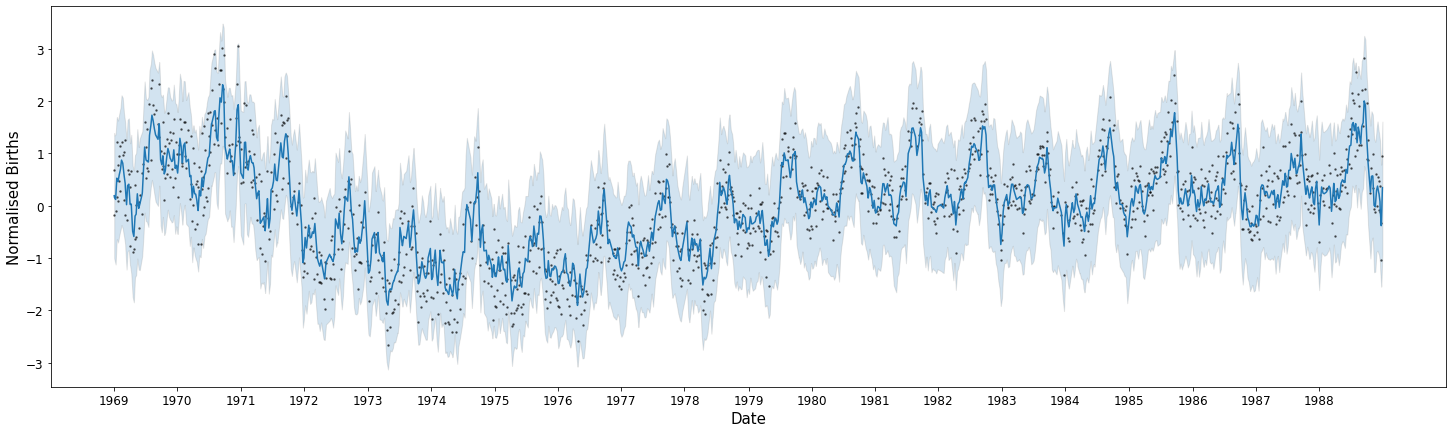

Testing Set


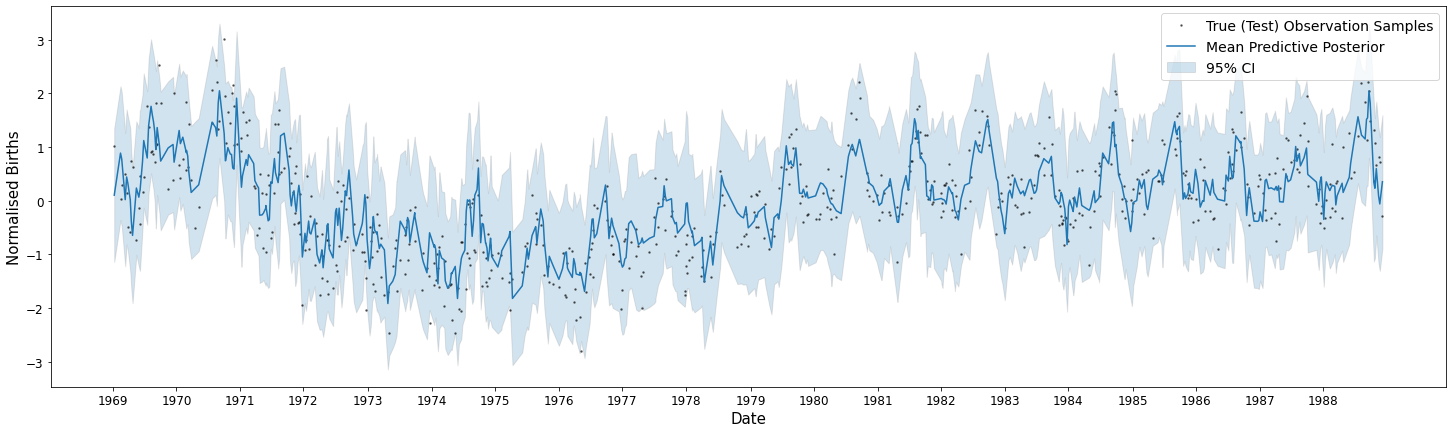

Train ELBO, MSE, MAE:  -1595.4370547436602 0.12360006135644488 0.7974687106239298 36.19070182022894
Test ELBO, MSE, MAE:  -2486.19853248223 0.34974574880584836 0.7354886327225081 28.16098532542753


name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[3.15781236e-03...
DeepGP.f_layers[0]._trainable_weights[1],ResourceVariable,,,True,"(1, 500500)",float64,"[[9.93280533e-01, -5.98456433e-04, 3.60641399e-05..."
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[0] DeepGP.f_layers[0]._metrics[0].total,ResourceVariable,,,False,(),float64,0.0001505535834182055
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[1] DeepGP.f_layers[0]._metrics[0].count,ResourceVariable,,,False,(),float64,7.0
DeepGP.f_layers[0]._self_tracked_trackables[1].variance DeepGP.f_layers[0].kernel.variance,Parameter,Softplus,,True,(),float64,0.04646767246341222
DeepGP.f_layers[0]._self_tracked_trackables[1].lengthscales DeepGP.f_layers[0].kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.8869962544955143
DeepGP.f_layers[0]._self_tracked_trackables[2].Z DeepGP.f_layers[0].inducing_variable.Z,Parameter,Identity,,True,"(1000, 1)",float64,[[4.27053102e+00...
DeepGP.f_layers[0]._self_tracked_trackables[4] DeepGP.f_layers[0].q_mu,Parameter,Identity,,True,"(1000, 1)",float64,[[3.15781236e-03...
DeepGP.f_layers[0]._self_tracked_trackables[5] DeepGP.f_layers[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 1000, 1000)",float64,"[[[9.98484036e-01, 0.00000000e+00, 0.00000000e+00..."
DeepGP.f_layers[1]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[2.50075246e-01...


: 

In [9]:
build_train_2layer_dgp(gpflow.kernels.RBF(), gpflow.kernels.RBF(), 
                        weekend_x_train, weekend_y_train, weekend_x_test, weekend_y_test, weekend_pos, weekend_labels, 
                        num_inducing=1000, batch_size=500)

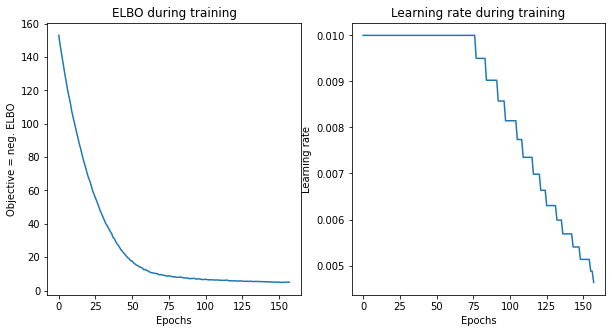

Training Set


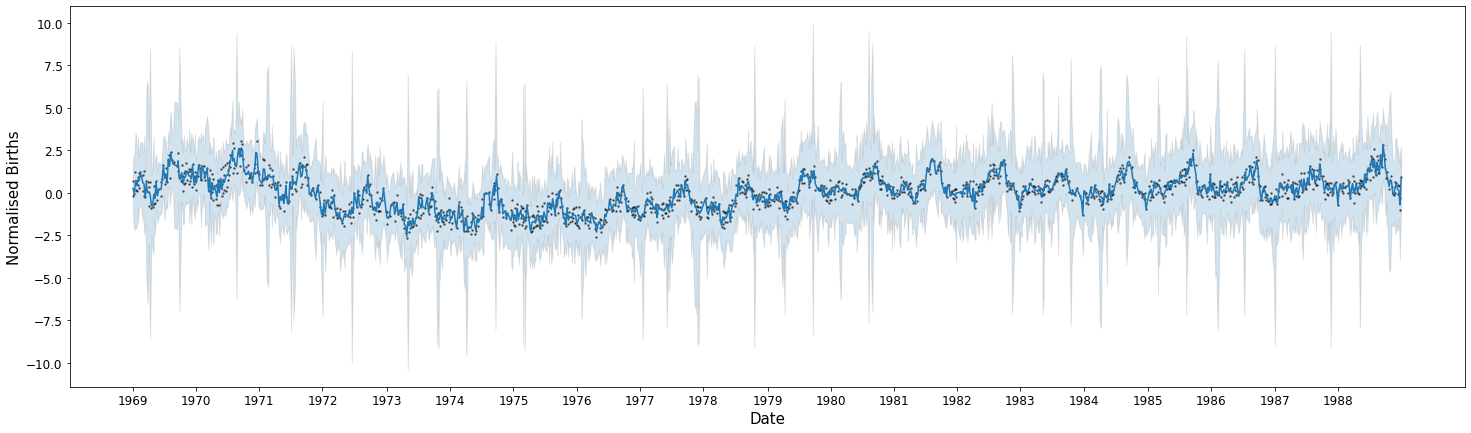

Testing Set


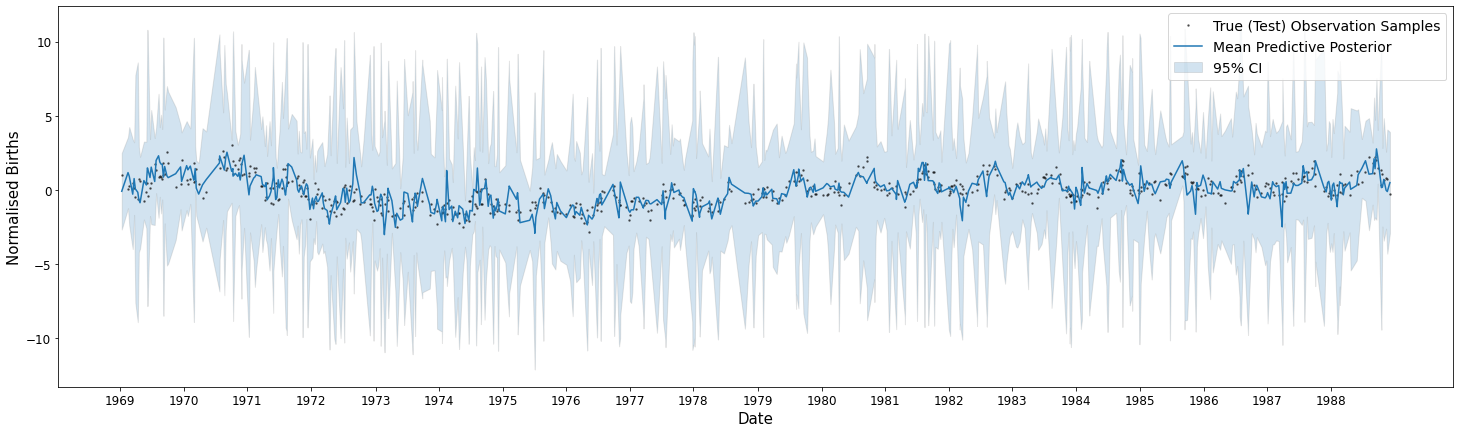

Train ELBO, MSE, MAE:  -7075.724071442842 0.09173990520221924 0.8185530656319181 16.305873522236816
Test ELBO, MSE, MAE:  -27709.677287083618 0.7268868950563241 0.9646018922491583 2.595585672896174


name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[-2.07658227e-01...
DeepGP.f_layers[0]._trainable_weights[1],ResourceVariable,,,True,"(1, 500500)",float64,"[[0.35661945, -0.09131671, 0.01971193..."
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[0] DeepGP.f_layers[0]._metrics[0].total,ResourceVariable,,,False,(),float64,3.8130619559264862
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[1] DeepGP.f_layers[0]._metrics[0].count,ResourceVariable,,,False,(),float64,7.0
DeepGP.f_layers[0]._self_tracked_trackables[1].variance DeepGP.f_layers[0].kernel.variance,Parameter,Softplus,,True,(),float64,0.648872313522152
DeepGP.f_layers[0]._self_tracked_trackables[1].lengthscales DeepGP.f_layers[0].kernel.lengthscales,Parameter,Softplus,,True,(),float64,4.144936815668837
DeepGP.f_layers[0]._self_tracked_trackables[2].Z DeepGP.f_layers[0].inducing_variable.Z,Parameter,Identity,,True,"(1000, 1)",float64,[[4.47886688e+00...
DeepGP.f_layers[0]._self_tracked_trackables[4] DeepGP.f_layers[0].q_mu,Parameter,Identity,,True,"(1000, 1)",float64,[[-2.07658227e-01...
DeepGP.f_layers[0]._self_tracked_trackables[5] DeepGP.f_layers[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 1000, 1000)",float64,"[[[2.63368913e-001, 0.00000000e+000, 0.00000000e+000..."
DeepGP.f_layers[1]._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[4.65567046e-02...


In [5]:
build_train_2layer_dgp(gpflow.kernels.RBF(1), gpflow.kernels.RBF(30), 
                        weekend_x_train, weekend_y_train, weekend_x_test, weekend_y_test, weekend_pos, weekend_labels, 
                        num_inducing=1000, batch_size=500)